In [44]:
'''
 * llewyn 17.03.15
 * 3 Layers Neural Network using creditcard.csv data in kaggle
'''
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import advanced_activations
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.optimizers import RMSprop

In [4]:
'''
-------------------- Preprocessing -------------------
 * Read csv data and split to label and features
 * Make dataframe to list in order to insert to train_test_split function.
'''

'''
 * bring the csv file to the dataframe variable without header
'''
dataframe = pd.read_csv('../../datasets/creditcard.csv', header=0)
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
'''
 * classify label and features
 * make label to one_hot using to_categorical in keras
'''
df_cp = dataframe.copy()
label = np.asarray(dataframe['Class'])
categorical_labels = to_categorical(label, 2)

In [6]:
categorical_labels.sum(axis=0)

array([ 284315.,     492.])

In [7]:
features = np.asarray(df_cp.values)[:,:-1]
timestamp = features[:,0]
timestamp = timestamp % (60* 60 * 24)
features -= features.min(axis=0)
features /= features.max(axis=0)
features[:1],features.shape

(array([[ 0.        ,  0.93519234,  0.76649042,  0.8813649 ,  0.31302266,
          0.76343873,  0.26766864,  0.26681518,  0.7864442 ,  0.47531173,
          0.51060048,  0.25248432,  0.68090763,  0.3715906 ,  0.63559053,
          0.4460837 ,  0.43439239,  0.73717255,  0.65506586,  0.59486323,
          0.58294223,  0.56118439,  0.52299212,  0.66379298,  0.39125268,
          0.58512179,  0.39455679,  0.41897614,  0.31269663,  0.00582379]]),
 (284807, 30))

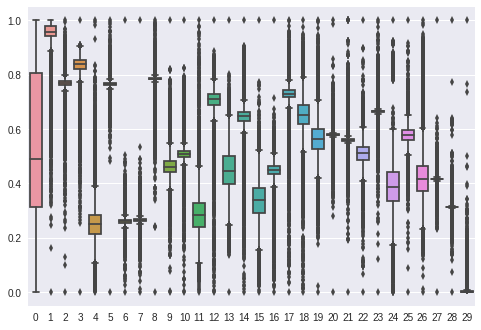

In [8]:
sns.boxplot(data=features[:,:])

In [9]:
'''
 * split train and test data using scikit learn
'''
X_train, X_test, y_train, y_test = train_test_split(features, categorical_labels, test_size=0.2, random_state=40)

In [76]:
'''
 * define numbers for deep learning
'''
FEATURE_NUM = 30
CLASSES = 2
HIDDEN1_SIZE = 100
HIDDEN2_SIZE = 50
MAX_RANGE = 100

In [77]:
print(X_train.shape)
print(y_train.sum(axis=0))
(227450-395)/(227450+395)

(227845, 30)
[ 227450.     395.]


0.9965327305843885

In [84]:
'''
----------------------- Modeling ----------------------
 * Keras is very comfortable. Just set up input_dimenstion at the first layer
  and don't need to do it after that.
 * All weights are initialized to 'uniform'
 * 1st Layer's Activation function is 'ELU'
 * 2nd Layer's Activation function is 'ELU'
 * 3rd Layer's(Output Layer) Activation function is 'softmax'
 * There are two Dropout function
 * Loss function is 'binary_crossentropy'
 * Optimizer function is 'Adam'
'''
model = Sequential()
model.add(BatchNormalization(input_shape=(FEATURE_NUM,)))
model.add(GaussianNoise(0.4))
model.add(Dense(HIDDEN1_SIZE))#, input_dim=FEATURE_NUM))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(HIDDEN1_SIZE))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(HIDDEN2_SIZE))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation='softmax'))

In [85]:
'''
 * tensorboard and checkpoints saver callbacks
 * Keras Tensorboard graph is not prettier than original Tensorflow graph, but much easier to use.
'''
checkpointer = ModelCheckpoint(filepath="/tmp/weights.hdf5",
                               verbose=1,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)
#opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [86]:
MAX_RANGE=10
model.fit(X_train, y_train,
          epochs =MAX_RANGE,
          batch_size=1000,
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, tensorboard])

Train on 227845 samples, validate on 56962 samples
Epoch 1/10
227845/227845 [==============================] - 2s - loss: 0.0651 - acc: 0.9794 - val_loss: 0.0104 - val_acc: 0.9983
Epoch 2/10
227845/227845 [==============================] - 2s - loss: 0.0099 - acc: 0.9985 - val_loss: 0.0039 - val_acc: 0.9992
Epoch 3/10
227845/227845 [==============================] - 2s - loss: 0.0080 - acc: 0.9988 - val_loss: 0.0028 - val_acc: 0.9995
Epoch 4/10
227845/227845 [==============================] - 2s - loss: 0.0066 - acc: 0.9988 - val_loss: 0.0029 - val_acc: 0.9995
Epoch 5/10
227845/227845 [==============================] - 2s - loss: 0.0064 - acc: 0.9990 - val_loss: 0.0030 - val_acc: 0.9994
Epoch 6/10
227845/227845 [==============================] - 2s - loss: 0.0059 - acc: 0.9990 - val_loss: 0.0029 - val_acc: 0.9995
Epoch 7/10
227845/227845 [==============================] - 2s - loss: 0.0060 - acc: 0.9990 - val_loss: 0.0030 - val_acc: 0.9995
Epoch 8/10
227845/227845 [====================

In [87]:
y_hat = model.predict_classes(X_test)
y_class_test = (y_test.argmax(axis=1))

56832/56962 [============================>.] - ETA: 0s  

In [88]:
print(len(np.nonzero(y_hat)[0]))

97


- [[56855    10]
  [   31    66]]
- [[56855    10]
 [   26    71]]
- [[56855    10]
 [   18    79]]
- [[56851    14]
 [   14    83]] 86%
- [[56849    16]
 [   13    84]] 85%
- [[56855    10]
 [   15    82]] 87%

In [89]:
print(y_hat.shape,y_class_test.shape)
print(sklearn.metrics.confusion_matrix(y_class_test,y_hat))
print(sklearn.metrics.classification_report(y_class_test,y_hat))

(56962,) (56962,)
[[56851    14]
 [   14    83]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56865
          1       0.86      0.86      0.86        97

avg / total       1.00      1.00      1.00     56962



## Nota extraída da competição: 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.